# Computer Vision Nanodegree

## Project: Image Captioning

---

In this notebook, you will use your trained model to generate captions for images in the test dataset.

This notebook **will be graded**.  

Feel free to use the links below to navigate the notebook:
- [Step 1](#step1): Get Data Loader for Test Dataset 
- [Step 2](#step2): Load Trained Models
- [Step 3](#step3): Finish the Sampler
- [Step 4](#step4): Clean up Captions
- [Step 5](#step5): Generate Predictions!

<a id='step1'></a>
## Step 1: Get Data Loader for Test Dataset

Before running the code cell below, define the transform in `transform_test` that you would like to use to pre-process the test images.  

Make sure that the transform that you define here agrees with the transform that you used to pre-process the training images (in **2_Training.ipynb**).  For instance, if you normalized the training images, you should also apply the same normalization procedure to the test images.

In [126]:
import sys
sys.path.append('/opt/cocoapi/PythonAPI')
from pycocotools.coco import COCO
from data_loader import get_loader
from torchvision import transforms

# TODO #1: Define a transform to pre-process the testing images.
transform_test = transforms.Compose([ 
    transforms.Resize((224,224)),                          # smaller edge of image resized to 224
    transforms.ToTensor(),                           # convert the PIL Image to a tensor
    transforms.Normalize((0.485, 0.456, 0.406),      # normalize image for pre-trained model
                         (0.229, 0.224, 0.225))])

#-#-#-# Do NOT modify the code below this line. #-#-#-#

# Create the data loader.
data_loader = get_loader(transform=transform_test,    
                         mode='test')

Vocabulary successfully loaded from vocab.pkl file!


Run the code cell below to visualize an example test image, before pre-processing is applied.

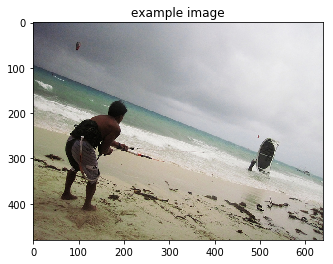

In [89]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Obtain sample image before and after pre-processing.
orig_image, image = next(iter(data_loader))

# Visualize sample image, before pre-processing.
plt.imshow(np.squeeze(orig_image))
plt.title('example image')
plt.show()

In [90]:
print(orig_image.shape)
print(image.shape)

torch.Size([1, 480, 640, 3])
torch.Size([1, 3, 224, 224])


In [4]:
# Visualize sample image, before pre-processing.
# plt.imshow(np.squeeze(image))
# plt.title('transformed image')
# plt.show()

<a id='step2'></a>
## Step 2: Load Trained Models

In the next code cell we define a `device` that you will use move PyTorch tensors to GPU (if CUDA is available).  Run this code cell before continuing.

In [91]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Before running the code cell below, complete the following tasks.

### Task #1

In the next code cell, you will load the trained encoder and decoder from the previous notebook (**2_Training.ipynb**).  To accomplish this, you must specify the names of the saved encoder and decoder files in the `models/` folder (e.g., these names should be `encoder-5.pkl` and `decoder-5.pkl`, if you trained the model for 5 epochs and saved the weights after each epoch).  

### Task #2

Plug in both the embedding size and the size of the hidden layer of the decoder corresponding to the selected pickle file in `decoder_file`.

In [92]:
# Watch for any changes in model.py, and re-load it automatically.
% load_ext autoreload
% autoreload 2

import os
import torch
from model import EncoderCNN, DecoderRNN

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
# models.py

import torch
import torch.nn as nn
import torchvision.models as models
import torch.nn.functional as F



class EncoderCNN(nn.Module):
    def __init__(self, embed_size):
        super(EncoderCNN, self).__init__()
        resnet = models.resnet50(pretrained=True)
        for param in resnet.parameters():
            param.requires_grad_(False)
        
        modules = list(resnet.children())[:-1]
        self.resnet = nn.Sequential(*modules)
        self.embed = nn.Linear(resnet.fc.in_features, embed_size)

    def forward(self, images):
        features = self.resnet(images)
        features = features.view(features.size(0), -1)
        features = self.embed(features)
        return features
    

class DecoderRNN(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers=1, pretrained_embeds=None, debug=False):
        super(DecoderRNN, self).__init__()
        
        self.hidden_size = hidden_size
        
        self.word_embeddings = nn.Embedding(vocab_size, embed_size)
        if pretrained_embeds is not None:
            # torch.from_numpy(pretrained_embeds)
            self.word_embeddings = self.word_embeddings.weight.data.copy_(pretrained_embeds)
            self.word_embeddings.weight.requires_grad = False
        
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers, batch_first=True)
        self.dec = nn.Linear(hidden_size, vocab_size)
        
        self.debug = debug
    
    def forward(self, features, captions):
        if self.debug:
            print('features: ', features.shape)
            print('captions: ', captions.shape)
        
        embeds = self.word_embeddings(captions[:,:-1])
        if self.debug:
            print('embeds: ', embeds.shape)
        
        features = features.unsqueeze(1)
        if self.debug:
            print('unsq feats: ', features.shape)
        
        inputs = (features, embeds)
        inputs = torch.cat(inputs,1)
        if self.debug:
            print('inputs: ', inputs.shape)
        
#         inputs = inputs.view(len(inputs), 1, -1)
#         print('inputs.view', inputs.shape)
        
        h_shape = (1, inputs.shape[0], self.hidden_size)
        if self.debug:
            print('h-shape: ', h_shape)
        
        hidden = (torch.randn(h_shape).cuda(), 
                  torch.randn(h_shape).cuda())  # clean out hidden state
        
        out, hidden = self.lstm(inputs, hidden)
        if self.debug:
            print('out: ', out.shape)
            print('hidden: ', hidden[0].shape)
        
        token_space = self.dec(out)
        if self.debug:
            print('token_space: ', token_space.shape)
        
#         token_scores = F.log_softmax(x, dim=1) # nn.CrossEntory takes care of this
#         if self.debug:
#             print('token_scores: ', token_scores.shape)
        
        return token_space

    def sample(self, inputs, states=None, max_len=20):
        " accepts pre-processed image tensor (inputs) and returns predicted sentence (list of tensor ids of length max_len) "
        output = []
        # clear hidden state
        h_shape = (1, inputs.shape[0], self.hidden_size)
        hidden = (torch.randn(h_shape).cuda(), torch.randn(h_shape).cuda())
        # loop until <end> token is sampled or maximum length is reached
#         out, hidden = self.lstm()
        for i in range(max_len):
            out, hidden = self.lstm(inputs, hidden)
            if self.debug:
                print('out: ', out.shape)
            
            x = self.dec(out)
            if self.debug:
                print('x: ', x.shape)
            
            values, tokens = torch.max(x, dim=-1)
            if self.debug:
                print('tokens: ',tokens)
            token = tokens.item()
            output.append(token)
            if token==1:
                break
            inputs = self.word_embeddings(tokens)
        return output

In [109]:
# TODO #2: Specify the saved models to load.
encoder_file = 'encoder-1.pkl'
decoder_file = 'decoder-1.pkl'

# TODO #3: Select appropriate values for the Python variables below.
embed_size = 300
hidden_size = 150

# The size of the vocabulary.
vocab_size = len(data_loader.dataset.vocab)

# Initialize the encoder and decoder, and set each to inference mode.
encoder = EncoderCNN(embed_size)

encoder.eval()
decoder = DecoderRNN(embed_size, hidden_size, vocab_size, debug=True)
decoder.eval()

# Load the trained weights.
# encoder.load_state_dict(torch.load(os.path.join('./models', encoder_file)))
# decoder.load_state_dict(torch.load(os.path.join('./models', decoder_file)))

# Move models to GPU if CUDA is available.
encoder.to(device)

decoder.to(device)

DecoderRNN(
  (word_embeddings): Embedding(8855, 300)
  (lstm): LSTM(300, 150, batch_first=True)
  (dec): Linear(in_features=150, out_features=8855, bias=True)
)

<a id='step3'></a>
## Step 3: Finish the Sampler

Before executing the next code cell, you must write the `sample` method in the `DecoderRNN` class in **model.py**.  This method should accept as input a PyTorch tensor `features` containing the embedded input features corresponding to a single image.

It should return as output a Python list `output`, indicating the predicted sentence.  `output[i]` is a nonnegative integer that identifies the predicted `i`-th token in the sentence.  The correspondence between integers and tokens can be explored by examining either `data_loader.dataset.vocab.word2idx` (or `data_loader.dataset.vocab.idx2word`).

After implementing the `sample` method, run the code cell below.  If the cell returns an assertion error, then please follow the instructions to modify your code before proceeding.  Do **not** modify the code in the cell below. 

In [111]:
import torch.utils.data as data

# (Optional) TODO #2: Amend the image transform below.
transform_train = transforms.Compose([ 
    transforms.Resize(256),                          # smaller edge of image resized to 256
    transforms.RandomAffine(degrees=15, translate=(.1,.1), shear=(10,10)),
    transforms.RandomCrop(224),                      # get 224x224 crop from random location
    transforms.RandomHorizontalFlip(),               # horizontally flip image with probability=0.5
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, 
                           hue=0.1),  # randomly change the brightness, contrast and saturation of an image
    transforms.ToTensor(),                           # convert the PIL Image to a tensor
    transforms.Normalize((0.485, 0.456, 0.406),      # normalize image for pre-trained model
                         (0.229, 0.224, 0.225))])

# Build data loader.
data_loader = get_loader(transform=transform_train,
                         mode='train',
                         batch_size=1,
                         vocab_from_file=True)

indices = data_loader.dataset.get_train_indices()
# Create and assign a batch sampler to retrieve a batch with the sampled indices.
new_sampler = data.sampler.SubsetRandomSampler(indices=indices)
data_loader.batch_sampler.sampler = new_sampler

# Obtain the batch.
images, captions = next(iter(data_loader))

images.shape

captions.shape

images = images.to(device)
captions = captions.to(device)
# Obtain the embedded image features.
features = encoder(images) #.unsqueeze(1)
output = decoder(features,captions)


features.shape

Vocabulary successfully loaded from vocab.pkl file!
loading annotations into memory...
Done (t=1.09s)
creating index...


  0%|          | 275/414113 [00:00<02:30, 2741.99it/s]

index created!
Obtaining caption lengths...


100%|██████████| 414113/414113 [01:39<00:00, 4161.95it/s]


features:  torch.Size([1, 300])
captions:  torch.Size([1, 11])
embeds:  torch.Size([1, 10, 300])
unsq feats:  torch.Size([1, 1, 300])
inputs:  torch.Size([1, 11, 300])
h-shape:  (1, 1, 150)
out:  torch.Size([1, 11, 150])
hidden:  torch.Size([1, 1, 150])
token_space:  torch.Size([1, 11, 8855])


torch.Size([1, 300])

In [116]:
output.view(-1, vocab_size)

tensor([[-3.7444e-01,  1.6306e-02,  1.9414e-02,  ..., -1.8607e-01,
          2.5882e-01,  2.6258e-03],
        [-1.9760e-01, -3.8339e-02,  3.7105e-03,  ..., -1.3751e-01,
          2.8966e-02,  5.1861e-02],
        [-1.7938e-01, -4.1485e-02, -4.3540e-02,  ..., -1.9916e-01,
         -4.7262e-02,  1.2968e-01],
        ...,
        [-1.5945e-01, -1.2983e-01, -4.9734e-02,  ..., -1.3366e-01,
         -1.3051e-01,  5.2557e-02],
        [-3.1132e-01,  1.6508e-02, -3.0191e-02,  ..., -6.0429e-02,
          8.9926e-02, -9.2601e-03],
        [-1.7633e-01,  3.9573e-02, -1.0336e-01,  ..., -1.7347e-01,
         -1.8418e-01, -9.2393e-02]], device='cuda:0')

In [120]:
torch.cat((captions,captions), dim=0 ).view(-1)

tensor([    0,     3,   699,    13,    51,   170,   192,  5501,  1539,
           18,     1,     0,     3,   699,    13,    51,   170,   192,
         5501,  1539,    18,     1], device='cuda:0')

In [110]:
# Move image Pytorch Tensor to GPU if CUDA is available.
image = image.to(device)
print(image.shape)

# Obtain the embedded image features.
features = encoder(image).unsqueeze(1)
print(features.shape)

# Pass the embedded image features through the model to get a predicted caption.
output = decoder.sample(features)
print('example output:', output)

assert (type(output)==list), "Output needs to be a Python list" 
assert all([type(x)==int for x in output]), "Output should be a list of integers." 
assert all([x in data_loader.dataset.vocab.idx2word for x in output]), "Each entry in the output needs to correspond to an integer that indicates a token in the vocabulary."

torch.Size([1, 3, 224, 224])
torch.Size([1, 1, 300])
out:  torch.Size([1, 1, 150])
x:  torch.Size([1, 1, 8855])
tokens:  tensor([[ 443]], device='cuda:0')
out:  torch.Size([1, 1, 150])
x:  torch.Size([1, 1, 8855])
tokens:  tensor([[ 5978]], device='cuda:0')
out:  torch.Size([1, 1, 150])
x:  torch.Size([1, 1, 8855])
tokens:  tensor([[ 8184]], device='cuda:0')
out:  torch.Size([1, 1, 150])
x:  torch.Size([1, 1, 8855])
tokens:  tensor([[ 76]], device='cuda:0')
out:  torch.Size([1, 1, 150])
x:  torch.Size([1, 1, 8855])
tokens:  tensor([[ 5406]], device='cuda:0')
out:  torch.Size([1, 1, 150])
x:  torch.Size([1, 1, 8855])
tokens:  tensor([[ 8524]], device='cuda:0')
out:  torch.Size([1, 1, 150])
x:  torch.Size([1, 1, 8855])
tokens:  tensor([[ 5626]], device='cuda:0')
out:  torch.Size([1, 1, 150])
x:  torch.Size([1, 1, 8855])
tokens:  tensor([[ 5016]], device='cuda:0')
out:  torch.Size([1, 1, 150])
x:  torch.Size([1, 1, 8855])
tokens:  tensor([[ 5710]], device='cuda:0')
out:  torch.Size([1, 1,

<a id='step4'></a>
## Step 4: Clean up the Captions

In the code cell below, complete the `clean_sentence` function.  It should take a list of integers (corresponding to the variable `output` in **Step 3**) as input and return the corresponding predicted sentence (as a single Python string). 

In [95]:
idx2word = data_loader.dataset.vocab.idx2word

In [96]:
# TODO #4: Complete the function.
def clean_sentence(output):
    sentence = ''
    for i in output:
        word = idx2word[i]
        sentence += word + ' '
    return sentence

After completing the `clean_sentence` function above, run the code cell below.  If the cell returns an assertion error, then please follow the instructions to modify your code before proceeding.

In [97]:
sentence = clean_sentence(output)
print('example sentence:', sentence)

assert type(sentence)==str, 'Sentence needs to be a Python string!'

example sentence: upset wi slat illuminated utilizing griddle sexy sugar boeing individually too paperback dandelions dreary angles fingertips kiteboarding former dish jockey 


<a id='step5'></a>
## Step 5: Generate Predictions!

In the code cell below, we have written a function (`get_prediction`) that you can use to use to loop over images in the test dataset and print your model's predicted caption.

In [123]:
def get_prediction():
    orig_image, image = next(iter(data_loader))
    plt.imshow(np.squeeze(orig_image))
    plt.title('Sample Image')
    plt.show()
    image = image.to(device)
    features = encoder(image).unsqueeze(1)
    output = decoder.sample(features)    
    sentence = clean_sentence(output)
    print(sentence)

Run the code cell below (multiple times, if you like!) to test how this function works.

TypeError: Invalid dimensions for image data

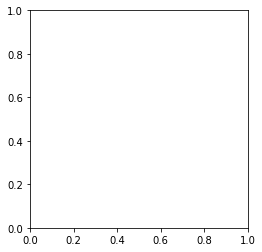

In [124]:
get_prediction()

As the last task in this project, you will loop over the images until you find four image-caption pairs of interest:
- Two should include image-caption pairs that show instances when the model performed well.
- Two should highlight image-caption pairs that highlight instances where the model did not perform well.

Use the four code cells below to complete this task.

### The model performed well!

Use the next two code cells to loop over captions.  Save the notebook when you encounter two images with relatively accurate captions.

TypeError: Invalid dimensions for image data

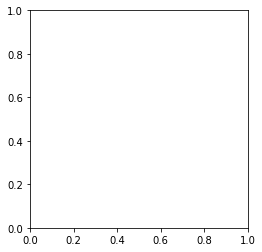

In [122]:
get_prediction()

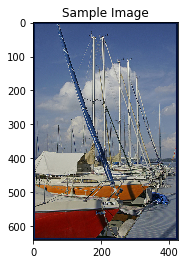

dusk aircraft herself perked pig corners rusted pinstripe rag slow its broadly roofed elf leather toilets free reacts fills grape 


In [101]:
get_prediction()

### The model could have performed better ...

Use the next two code cells to loop over captions.  Save the notebook when you encounter two images with relatively inaccurate captions.

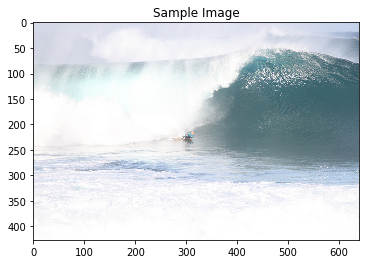

sprayer magnetic banners rowboats filming salad curio attraction chugs kittens colts bib beyond but clementines landed hash landmark goalie plater 


In [102]:
get_prediction()

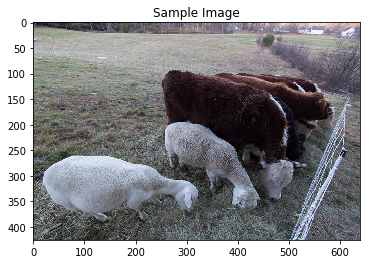

hooves strange gallops peers supreme sunk placemats feild motorboat penguins holders dedicated relax cherries stream labrador obama wind sparsely one 


In [103]:
get_prediction()

### Plotting loss and perplexity

In [104]:
import pandas as pd

# find out where the log file is
!ls 

0_Dataset.ipynb				      images
0_Dataset-zh.ipynb			      model.py
1_Preliminaries.ipynb			      models
1_Preliminaries-zh.ipynb		      __pycache__
2_Training.ipynb			      training_log1571315322.txt
2_Training-zh.ipynb			      training_log_1571315823.txt
3_Inference.ipynb			      training_log_1571316251.txt
3_Inference-zh.ipynb			      training_log-Copy1.txt
4_Zip Your Project Files and Submit.ipynb     training_log_lr2.txt
4_Zip Your Project Files and Submit-zh.ipynb  training_log.txt
data_loader.py				      vocab.pkl
filelist.txt				      vocabulary.py


In [105]:
log_fn = 'training_log_1571316251.txt'
with open(log_fn, 'r') as f:
    log = f.readlines()

log = [l.replace('\n','').split(',') for l in log]
log = [[l.replace(' [', ': ').split('/',1)[0] for l in lo] for lo in log]
log_dict = [{l.split(':')[0].strip():float(l.split(':')[1]) for l in lo} for lo in log]

df = pd.DataFrame(log_dict)

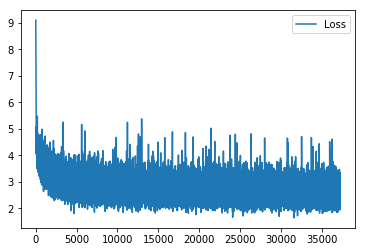

In [106]:
df[['Loss']].plot()

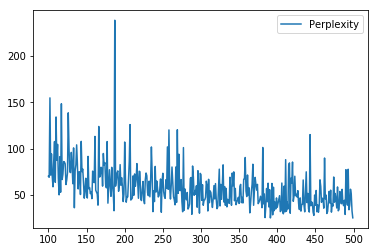

In [107]:
# ignore the outliers at the beginning
df[['Perplexity']][100:500].plot()

In [71]:
!top

=top - 08:58:30 up  1:05,  0 users,  load average: 1.16, 1.13, 1.05
Tasks:   5 total,   2 running,   3 sleeping,   0 stopped,   0 zombie
%Cpu(s): 16.7 us,  1.5 sy,  0.2 ni, 80.7 id,  0.6 wa,  0.0 hi,  0.2 si,  0.0 st
KiB Mem : 16425732 total,  2209484 free,  4697920 used,  9518328 buff/cache
KiB Swap: 20971516 total, 20971516 free,        0 used. 11285244 avail Mem 

  PID USER      PR  NI    VIRT    RES    SHR S  %CPU %MEM     TIME+ COMMAND     
   11 root      20   0 40.051g 2.167g 322216 R 100.0 13.8  42:07.30 python      
    1 root      20   0  355180  68592  13644 S   6.7  0.4   0:35.39 jupyter-no+ 
   42 root      20   0 40.233g 2.240g 290444 S   0.0 14.3   0:44.52 python      
   85 root      20   0    4504    688    620 S   0.0  0.0   0:00.65 sh          
   86 root      20   0   40408   3504   3076 R   0.0  0.0   0:00.00 top         
>


In [ ]:
class Attention(nn.Module):
    def __init__(self, encoder_dim, decoder_dim, attention_dim):
        super(Attention, self).__init__()
        self.encoder_att = nn.Linear(encoder_dim, attention_dim)  # linear layer to transform encoded image
        self.decoder_att = nn.Linear(decoder_dim, attention_dim)  # linear layer to transform decoder's output
        self.full_att = nn.Linear(attention_dim, 1)  # linear layer to calculate values to be softmax-ed
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)  # softmax layer to calculate weights

    def forward(self, encoder_out, decoder_hidden):
        att1 = self.encoder_att(encoder_out)  # (batch_size, num_pixels, attention_dim)
        att2 = self.decoder_att(decoder_hidden)  # (batch_size, attention_dim)
        att = self.full_att(self.relu(att1 + att2.unsqueeze(1))).squeeze(2)  # (batch_size, num_pixels)
        alpha = self.softmax(att)  # (batch_size, num_pixels)
        attention_weighted_encoding = (encoder_out * alpha.unsqueeze(2)).sum(dim=1)  # (batch_size, encoder_dim)

        return attention_weighted_encoding, alpha

class AttentionDecoderRNN(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers=1, pretrained_embeds=None, debug=False):
        super(DecoderRNN, self).__init__()
        
        self.hidden_size = hidden_size
        
        self.word_embeddings = nn.Embedding(vocab_size, embed_size)
        if pretrained_embeds is not None:
            # torch.from_numpy(pretrained_embeds)
            self.word_embeddings = self.word_embeddings.weight.data.copy_(pretrained_embeds)
            self.word_embeddings.weight.requires_grad = False
        
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers, batch_first=True)
        self.dec = nn.Linear(hidden_size, vocab_size)
        
        self.debug = debug
    
    def forward(self, features, captions):
        if self.debug:
            print('features: ', features.shape)
            print('captions: ', captions.shape)
        
        embeds = self.word_embeddings(captions[:,:-1])
        if self.debug:
            print('embeds: ', embeds.shape)
        
        features = features.unsqueeze(1)
        if self.debug:
            print('unsq feats: ', features.shape)
        
        inputs = (features, embeds)
        inputs = torch.cat(inputs,1)
        if self.debug:
            print('inputs: ', inputs.shape)
        
#         inputs = inputs.view(len(inputs), 1, -1)
#         print('inputs.view', inputs.shape)
        
        h_shape = (1, inputs.shape[0], self.hidden_size)
        if self.debug:
            print('h-shape: ', h_shape)
        
        hidden = (torch.randn(h_shape).cuda(), 
                  torch.randn(h_shape).cuda())  # clean out hidden state
        
        out, hidden = self.lstm(inputs, hidden)
        if self.debug:
            print('out: ', out.shape)
            print('hidden: ', hidden[0].shape)
        
        token_space = self.dec(out)
        if self.debug:
            print('token_space: ', token_space.shape)
        
#         token_scores = F.log_softmax(x, dim=1) # nn.CrossEntory takes care of this
#         if self.debug:
#             print('token_scores: ', token_scores.shape)
        
        return token_space

    def sample(self, inputs, states=None, max_len=20):
        " accepts pre-processed image tensor (inputs) and returns predicted sentence (list of tensor ids of length max_len) "
        output = []
        # clear hidden state
        h_shape = (1, inputs.shape[0], self.hidden_size)
        hidden = (torch.randn(h_shape).cuda(), torch.randn(h_shape).cuda())
        # loop until <end> token is sampled or maximum length is reached
#         out, hidden = self.lstm()
        for i in range(max_len):
            out, hidden = self.lstm(inputs, hidden)
            if self.debug:
                print('out: ', out.shape)
            
            x = self.dec(out)
            if self.debug:
                print('x: ', x.shape)
            
            values, tokens = torch.max(x, dim=-1)
            if self.debug:
                print('tokens: ',tokens)
            token = tokens.item()
            output.append(token)
            if token==1:
                break
            inputs = self.word_embeddings(tokens)
        return output